# 1.0 Introduction
Learning rate is one of the most important hyperparameter in any Neoral network. We spend a lot of time to find suitable learning rate for out model. On 2015 [Leslie Smith]((http://arxiv.org/abs/1506.01186)) published a simple way of finding learning rate. Today we are going to learn that idea and then will implement it in out model using keras.

The idea is actually very simple. We will start training out model using a very low learning rate then exponentially increase that over iteration. In the mean time we will save our learning rate along with our loss and iteration. We will stop this procedure when loss start to jump.
Pretty simple, right?

We will use our [simple 4 layer model](http://puzzlemusa.com/2018/04/24/resnet-in-keras/) to classify cifar10 dataset.

# 1.1 Importing libraries

In [0]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D
from keras.callbacks import Callback
import os
import keras.backend as K

Using TensorFlow backend.


# 1.2 Initialization

In [0]:
bs = 64
num_classes = 10
epochs = 5

# 1.3 Collecting data

In [4]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train  /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


# 2.1 Model

In [0]:
def four_layer_model():
 
    model = Sequential()
  
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=x_train.shape[1:]))
    
    model.add(Conv2D(32,(3, 3), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.25))
 
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.25))
 
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
 
    return model

# 2.2 Learning rate finder
If we go through this [fit_loop method](https://github.com/keras-team/keras/blob/master/keras/engine/training_arrays.py), we can see it takes a callback array. Here we are going to use this callback. To utilize this we are creating a new class *LR_Finder* inherited from keras [Callback](https://github.com/keras-team/keras/blob/master/keras/callbacks.py). Basically when we will call *fit* method of our model this *fit_loop* method will be called.

As loss may up-down a bit we will have scattered plot. In that case we are also calculating a smoother loss using linear interpolation

In [0]:
class LR_Finder(Callback):
    
    def __init__(self, start_lr=1e-5, end_lr=10, step_size=None, beta=.98):
        super().__init__()
        
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.step_size = step_size
        self.beta = beta
        self.lr_mult = (end_lr/start_lr)**(1/step_size)
        
    def on_train_begin(self, logs=None):
        self.best_loss = 1e9
        self.avg_loss = 0
        self.losses, self.smoothed_losses, self.lrs, self.iterations = [], [], [], []
        self.iteration = 0
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.start_lr)
        
    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        
        
        self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * loss
        smoothed_loss = self.avg_loss / (1 - self.beta**self.iteration)
        
        # Check if the loss is not exploding
        if self.iteration>1 and smoothed_loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if smoothed_loss < self.best_loss or self.iteration==1:
            self.best_loss = smoothed_loss
        
        lr = self.start_lr * (self.lr_mult**self.iteration)
        
        self.iteration += 1
        self.losses.append(loss)
        self.smoothed_losses.append(smoothed_loss)
        self.lrs.append(lr)
        self.iterations.append(self.iteration)
        
        
        K.set_value(self.model.optimizer.lr, lr)  
        
    def plot_lr(self):
        plt.xlabel('Iterations')
        plt.ylabel('Learning rate')
        plt.plot(self.iterations, self.lrs)
        
    def plot(self, n_skip=10):
        plt.ylabel('Loss')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_smoothed_loss(self, n_skip=10):
        plt.ylabel('Smoothed Losses')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.smoothed_losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_loss(self):
        plt.ylabel('Losses')
        plt.xlabel('Iterations')
        plt.plot(self.iterations[10:], self.losses[10:])

# 2.3 Finding learning rate

In [0]:
model4 = four_layer_model()
model4.compile(loss='categorical_crossentropy', optimizer='ADAM', metrics=['accuracy'])

In [8]:
lr_finder = LR_Finder(start_lr=1e-5, end_lr=10, step_size=np.ceil(x_train.shape[0]/bs))
model4.fit(x_train, y_train, callbacks=[lr_finder] )

Epoch 1/1
  288/50000 [..............................] - ETA: 3:07 - loss: 2.3226 - acc: 0.1007

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in double_scalars


26464/50000 [==============>...............] - ETA: 17s - loss: 2.8217 - acc: 0.1334

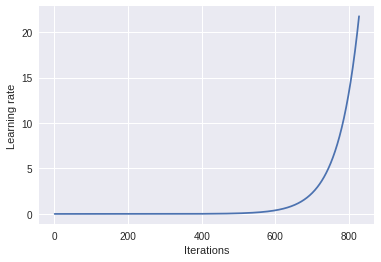

In [9]:
lr_finder.plot_lr()

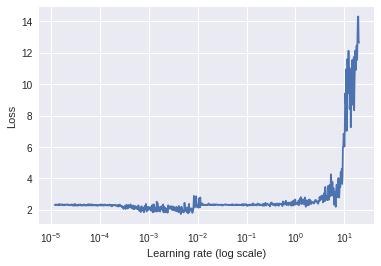

In [10]:
lr_finder.plot()

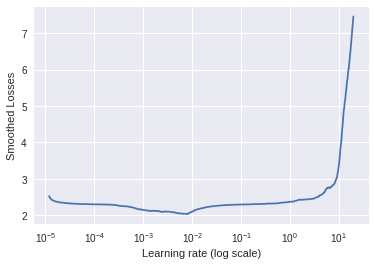

In [11]:
lr_finder.plot_smoothed_loss()

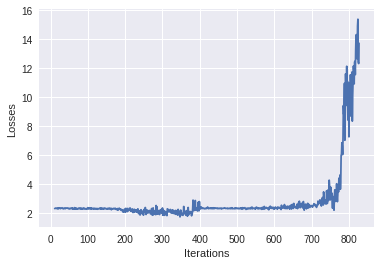

In [12]:
lr_finder.plot_loss()

References:

1.   https://github.com/nathanhubens/Learning-Rate
2.   [fastai mooc](http://course.fast.ai/)

